<a href="https://colab.research.google.com/github/gusthcf/ia-ufop/blob/main/Apresentacao-disciplina/Agentes-implementacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação - Smart house**

A seguir, vamos apresentar a implementação de uma possível funcionalidade de um Data Center.

Imagine que a implementação simule um agente que gerencia o uso de energia em um data center, comparando duas estratégias:
1. Média histórica simples do preço da energia.
2. Média móvel dos últimos 5 dias.


# Importar bibliotecas necessárias para executar o código


In [45]:
from random import *
import matplotlib.pyplot as plt
import numpy as np

# Definição do ambiente

Vamos armazenar no ambiente as seguintes informações:

*   Informação do dia
*   Preço do produto em cada um dos dias da série
*   Histórico de preços
*   Histórico de estoque
*   Histórico com a quantidade de produtos comprados

In [46]:
# Definicao da classe ambiente
class Ambiente():

  def __init__(self):
    # Ambiente explorado pelo agente de compra de papel higienico
    self.num_dias=0
    self.estoque=300 # Valor do estoque inicial
    self.historico_preco=[1.25]
    self.historico_estoque=[self.estoque]
    self.historico_qtde_comprados=[0]

  def percebe_preco_atual(self):
    return self.historico_preco[len(self.historico_preco)-1]

  def percebe_estoque(self):
    return self.historico_estoque[len(self.historico_estoque)-1]

  def run(self, dic_acoes):
    '''Realizar alteracoes no ambiente:
       Definir, aleatoriamente, uma quantidade de produtos consumidos
       Atualizar o historico do preco atual e do estoque.
       Essas informacoes serao utilizadas pelo agente para decidir a compra ou nao de produtos
    '''
    # Consumo realizado (valores gerados aleatoriamente)
    qtde_consumidos = randint(200,400) # recebe aleatoriamente valores entre 200 e 400 [start, end] - Intervalo fechado
    estoque_atual = self.historico_estoque[len(self.historico_estoque)-1] - qtde_consumidos + dic_acoes["comprar"]
    self.historico_estoque.append(estoque_atual)
    self.historico_qtde_comprados.append(dic_acoes["comprar"])

    # Informando valor do produto no periodo (Atualizacao para o proximo dia)
    valor = 0.5 + 1.5 * random() # novo valor do produto. random() gera valores entre [0,1]
    self.historico_preco.append(valor)

# Definição do agente

O agente vai armazenar informações sobre:
*   Ambiente (Composição de classes)
*   Valor médio das compras
*   Informação do último valor do produto
*   Informação sobre o estoque atual de produtos na casa

In [50]:
# Definição da classe agente

class Agente():

  def __init__(self, ambiente):
    self.num_dias = 1
    self.ambiente= ambiente
    self.estoque= ambiente.percebe_estoque()
    self.total_gasto = 0
    self.preco_atual = self.media = ambiente.percebe_preco_atual()

  def executa_agente(self, qtde_dias=20):

    for i in range(qtde_dias):
      # O agente percebe o estado do ambiente
      self.estoque= self.ambiente.percebe_estoque()
      self.preco_atual= self.ambiente.percebe_preco_atual()

      '''
        Controlador do agente:
        - Define a regra para compra de produtos
      '''
      if self.estoque <= 0:
        break
      elif self.preco_atual < 0.8 * self.media:
        compra= 500 - self.estoque
        if compra > 300:
          compra = 300
      elif self.estoque <= 400:
        compra = 401 - self.estoque
      else:
        compra= 0

      # Fim do controlador
      self.total_gasto += self.preco_atual*compra
      # O agente aplica modificacoes ao ambiente)
      self.ambiente.run({"comprar": compra})

      self.num_dias+=1
      self.media = (self.media*(self.num_dias-1) + self.preco_atual)/self.num_dias

# Definir classe para impressão dos resultados


In [51]:
class Imprime():
  def imprime_resultado(agente):
    historico_dias = np.linspace(0, agente.num_dias, agente.num_dias)

    # Primeira impressão: historico do preco
    plt.plot(historico_dias, agente.ambiente.historico_preco, 'bo--', label='Historico (preço)')
    plt.legend()
    plt.show()

    # Segunda impressão: historico qtde itens comprados
    fig, ax = plt.subplots()
    ax.vlines(historico_dias, ymin=0, ymax=agente.ambiente.historico_qtde_comprados)
    ax.plot(historico_dias, agente.ambiente.historico_qtde_comprados, "go")
    ax.set_ylim(0, 500)
    plt.show()

    # Terceira impressão: historico do estoque
    plt.plot(historico_dias, agente.ambiente.historico_estoque, 'rD--', label='Historico (estoque)')
    plt.legend()
    plt.show()

    print(agente.total_gasto)



# Execução do programa

Por um determinado número de iterações, vamos gerar valores aleatórios para o preco do papel higienico e a quantidade de produto consumido

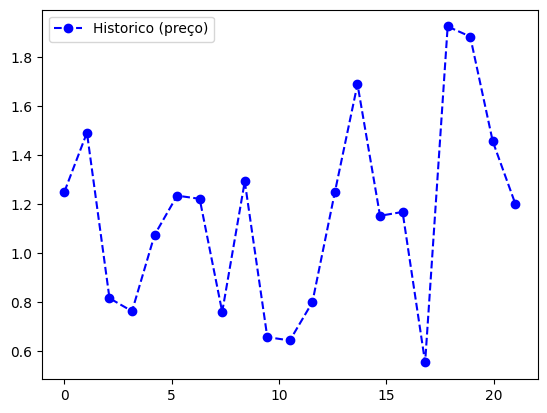

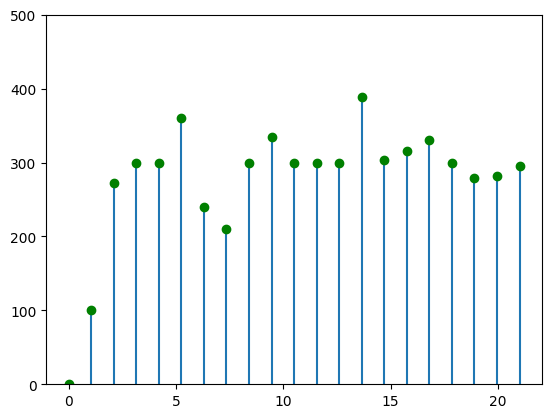

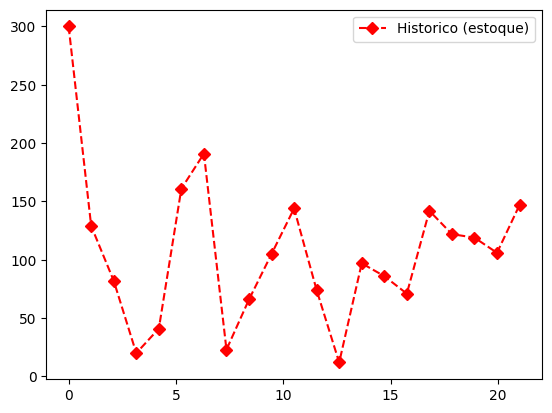

6648.3635796444305


In [54]:
ambiente_atuacao = Ambiente()
smart_house = Agente(ambiente_atuacao)
smart_house.executa_agente(20)


Imprime.imprime_resultado(smart_house)